In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import spiceypy as sp
from ATATools import ata_ephem
from ATATools import ata_control as ac

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
sp.furnsh('spice/naif0012.tls')
sp.furnsh('spice/de424.bsp')
sp.furnsh('spice/pck00010.tpc')
sp.furnsh('spice/orx_230117_231101_230911_od368-N-TCM12-P-DB1_v1.bsp')
sp.furnsh('spice/ata.bsp')
sp.furnsh('spice/ata.tf')
sp.furnsh('spice/earth_latest_high_prec.bpc')
sp.boddef('ATA', 399999)

In [3]:
begin = np.datetime64('2023-09-24T14:38:30')
end = np.datetime64('2023-09-24T14:46:30')
t_step = (0.1 * 1e9) * np.timedelta64(1, 'ns')
t_axis = begin + np.arange((end - begin) / t_step + 1) * t_step

In [4]:
j2000_unix = (np.datetime64('2000-01-01T12:00') - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
pos = np.empty((t_axis.size, 3))
t_tai = np.empty(t_axis.size)
for j, utc in enumerate(t_axis):
    et = sp.utc2et(str(utc))
    pos[j] = sp.spkpos('orx', et, 'ATA_TOPO', 'LT+S', 'ATA')[0]
    t_tai[j] = sp.unitim(et, 'ET', 'TAI') + j2000_unix

In [5]:
dist = np.sqrt(np.sum(pos**2, axis=1))
elev = np.rad2deg(np.arcsin(pos[:, 2] / dist))
azim = np.rad2deg(np.angle(pos[:, 0] - 1j * pos[:, 1])) % 360

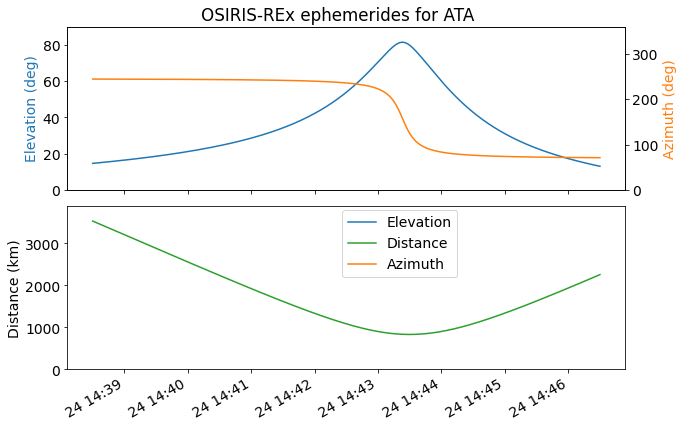

In [6]:
fig, axs = plt.subplots(2, figsize=(10, 7), sharex=True)
axs[0].plot(t_axis, elev, label='Elevation')
axs[0].set_ylabel('Elevation (deg)', color='C0')
axs[0].set_ylim(0, 90)
ax2 = axs[0].twinx()
ax2.set_ylabel('Azimuth (deg)', color='C1')
ax2.plot(t_axis, azim, color='C1', label='Azimuth')
ax2.set_ylim(0, 360)
axs[1].plot(t_axis, dist, color='C2', label='Distance')
axs[1].set_ylabel('Distance (km)')
axs[1].set_ylim(0, np.max(dist) * 1.1)
fig.autofmt_xdate()
plt.subplots_adjust(hspace=0.1)
fig.legend(loc=[0.5, 0.35])
plt.suptitle('OSIRIS-REx ephemerides for ATA', y=0.92);

In [7]:
#time_translate = (np.datetime64('2023-09-23T16:02:00') - begin) / np.timedelta64(1, 's') # REMOVE BEFORE FLIGHT
ir = t_axis.size * [1e-10]
ephem = np.array([t_tai * 1e9, azim, elev, ir], dtype='object').T
ephem_path = '/tmp/orx.eph'
ata_ephem.ephem_to_txt('/tmp/orx.eph', ephem)

In [8]:
##eph_id = ac.upload_ephemeris(ephem_path)
# old feeds: 1a, 1f, 4g, 5c
##antennas = ['1a', '5c']
##ac.track_ephemeris(eph_id, antennas)

# Tests

In [9]:
test1 = np.load('test2-azel.npz')

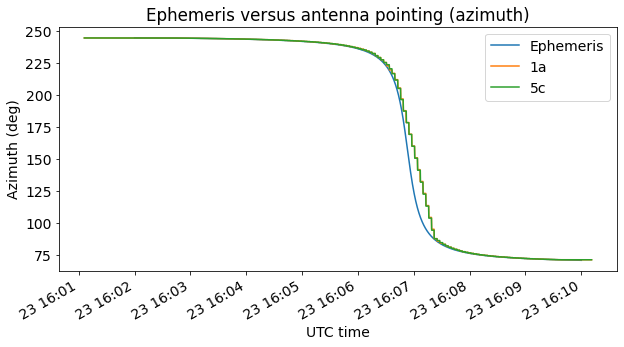

In [10]:
#t_axis_shift = t_axis - t_axis[0] + np.datetime64('2023-09-23T15:30:00')
t_axis_shift = t_axis - t_axis[0] + np.datetime64('2023-09-23T16:02:00')
plt.plot(t_axis_shift, azim, label='Ephemeris')
plt.plot(test1['times'], test1['azels_1a'][:, 0], label='1a')
plt.plot(test1['times'], test1['azels_5c'][:, 0], label='5c')
plt.title('Ephemeris versus antenna pointing (azimuth)')
plt.xlabel('UTC time')
plt.ylabel('Azimuth (deg)')
plt.legend()
plt.gcf().autofmt_xdate();

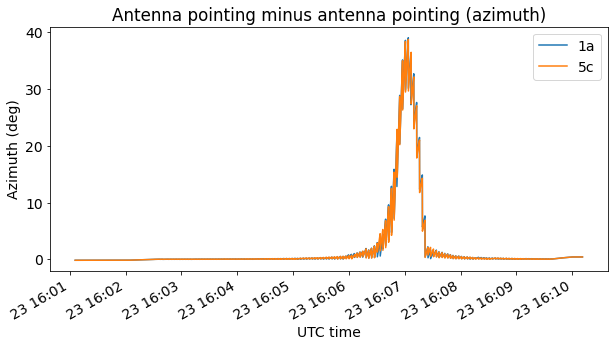

In [11]:
t0 = t_axis_shift[0]
sec = np.timedelta64(1, 's')
azim_interp = np.interp((test1['times'] - t0) / sec, (t_axis_shift - t0) / sec, azim)
plt.plot(test1['times'], test1['azels_1a'][:, 0] - azim_interp, label='1a')
plt.plot(test1['times'], test1['azels_5c'][:, 0] - azim_interp, label='5c')
plt.title('Antenna pointing minus antenna pointing (azimuth)')
plt.xlabel('UTC time')
plt.ylabel('Azimuth (deg)')
plt.legend()
plt.gcf().autofmt_xdate();

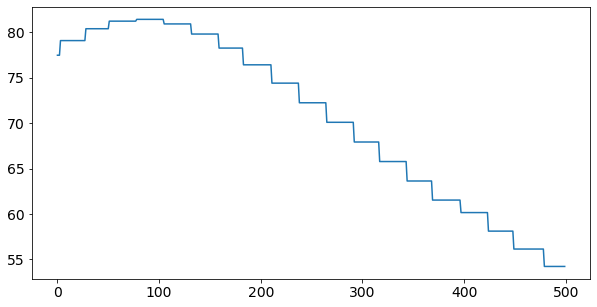

In [12]:
plt.plot(test1['azels_1a'][3000:3500, 1])

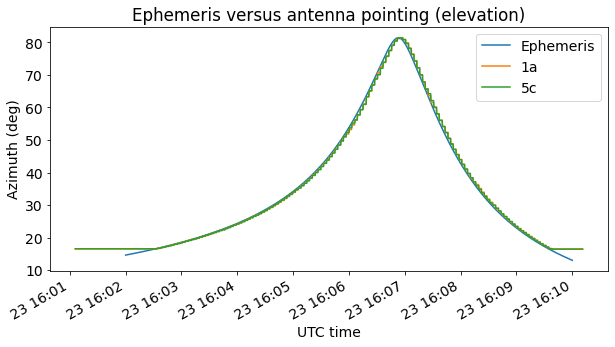

In [13]:
plt.plot(t_axis_shift, elev, label='Ephemeris')
plt.plot(test1['times'], test1['azels_1a'][:, 1], label='1a')
plt.plot(test1['times'], test1['azels_5c'][:, 1], label='5c')
plt.title('Ephemeris versus antenna pointing (elevation)')
plt.xlabel('UTC time')
plt.ylabel('Azimuth (deg)')
plt.legend()
plt.gcf().autofmt_xdate();

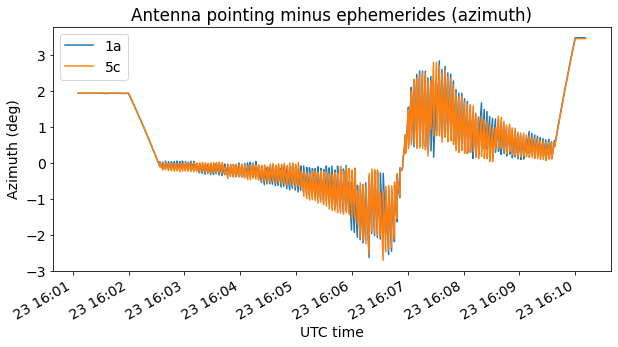

In [14]:
elev_interp = np.interp((test1['times'] - t0) / sec, (t_axis_shift - t0) / sec, elev)
plt.plot(test1['times'], test1['azels_1a'][:, 1] - elev_interp, label='1a')
plt.plot(test1['times'], test1['azels_5c'][:, 1] - elev_interp, label='5c')
plt.title('Antenna pointing minus ephemerides (azimuth)')
plt.xlabel('UTC time')
plt.ylabel('Azimuth (deg)')
plt.legend()
plt.gcf().autofmt_xdate();

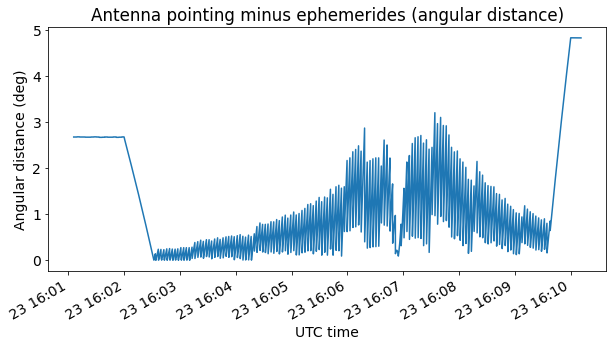

In [15]:
plt.plot(test1['times'], np.sqrt((test1['azels_1a'][:, 1] - elev_interp)**2 
        + (np.cos(np.deg2rad(elev_interp)) * (test1['azels_1a'][:, 1] - elev_interp))**2))
plt.title('Antenna pointing minus ephemerides (angular distance)')
plt.xlabel('UTC time')
plt.ylabel('Angular distance (deg)')
plt.gcf().autofmt_xdate();